<a href="https://colab.research.google.com/github/mohanrajmit/SignatureVerification/blob/main/siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siemese Network

# Fruits-360: A dataset of images containing fruits and vegetables
##### A high-quality, dataset of images containing fruits and vegetables. The following fruits and vegetables are included: Apples (different varieties: Crimson Snow, Golden, Golden-Red, Granny Smith, Pink Lady, Red, Red Delicious), Apricot, Avocado, Avocado ripe, Banana (Yellow, Red, Lady Finger), Beetroot Red, Blueberry, Cactus fruit, Cantaloupe (2 varieties), Carambula, Cauliflower, Cherry (different varieties, Rainier), Cherry Wax (Yellow, Red, Black), Chestnut, Clementine, Cocos, Corn (with husk), Cucumber (ripened), Dates, Eggplant, Fig, Ginger Root, Granadilla, Grape (Blue, Pink, White (different varieties)), Grapefruit (Pink, White), Guava, Hazelnut, Huckleberry, Kiwi, Kaki, Kohlrabi, Kumsquats, Lemon (normal, Meyer), Lime, Lychee, Mandarine, Mango (Green, Red), Mangostan, Maracuja, Melon Piel de Sapo, Mulberry, Nectarine (Regular, Flat), Nut (Forest, Pecan), Onion (Red, White), Orange, Papaya, Passion fruit, Peach (different varieties), Pepino, Pear (different varieties, Abate, Forelle, Kaiser, Monster, Red, Stone, Williams), Pepper (Red, Green, Orange, Yellow), Physalis (normal, with Husk), Pineapple (normal, Mini), Pitahaya Red, Plum (different varieties), Pomegranate, Pomelo Sweetie, Potato (Red, Sweet, White), Quince, Rambutan, Raspberry, Redcurrant, Salak, Strawberry (normal, Wedge), Tamarillo, Tangelo, Tomato (different varieties, Maroon, Cherry Red, Yellow, not ripened, Heart), Walnut, Watermelon.

# Dataset properties

The images used here are a sample from the original images

Total number of images used for training: 5047 images (one fruit or vegetable per image).

Number of classes: 30 (fruits and vegetables).

Image size: 100x100 pixels.

## Dataset Source
#### https://github.com/Horea94/Fruit-Images-Dataset

## License
#### https://github.com/Horea94/Fruit-Images-Dataset/blob/master/LICENSE

In [1]:
!git clone https://github.com/Horea94/Fruit-Images-Dataset

Cloning into 'Fruit-Images-Dataset'...
remote: Enumerating objects: 385858, done.
remote: Counting objects: 100% (8693/8693), done.
remote: Compressing objects: 100% (8659/8659), done.
remote: Total 385858 (delta 37), reused 8688 (delta 34), pack-reused 377165
Receiving objects: 100% (385858/385858), 2.10 GiB | 29.24 MiB/s, done.
Resolving deltas: 100% (1197/1197), done.
Checking out files: 100% (90503/90503), done.


In [2]:
# Import necessary libraries
import re
import numpy as np
from PIL import Image
import cv2
import random

from sklearn.model_selection import train_test_split
from keras import backend as K
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import InputLayer, Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop

import tensorflow as tf

In [3]:
# Initialize input values such as margin, input image size(height, width), epochs, batch_size and output classes for this example
epochs = 10
batch_size = 10
margin = 1  
output_classes = 2
img_height = 256
img_width = 256

In [4]:
!mkdir /content/train 

In [5]:
!mv /content/Fruit-Images-Dataset/Training/Banana /content/train

In [6]:
!mv /content/Fruit-Images-Dataset/Training/Beetroot /content/train

In [7]:
# Set the data directory for the dataset
import pathlib
data_dir = pathlib.Path('/content/train')
data_dir

PosixPath('/content/train')

In [8]:
data_dir

PosixPath('/content/train')

In [9]:
# Find all .jpg files in data_dir
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count  # the count of all .jpg files in data_dir

940

In [10]:
# get all image files of Apple Braeburn class in a list called "fruits"
fruits = list(data_dir.glob('Banana/*'))
print(len(fruits))
cv2.imread(str(fruits[0])).shape # read first image of Apple Braeburn class

490


(100, 100, 3)

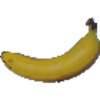

In [11]:
Image.open(str(fruits[0])) # display the image

In [12]:
cv2.imread(str(fruits[5])).shape  # read fifth image of Apple Braeburn class

(100, 100, 3)

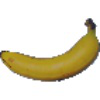

In [13]:
Image.open(str(fruits[5])) # display the image

In [14]:
len(fruits) # It will display total number of Apple Braeburn fruit

490

In [15]:
!mv /content/Fruit-Images-Dataset/Training/Cauliflower /content/train

In [16]:
# Generate a tf.data.Dataset from image files in a train directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, # 80% train data 20% for validation data
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1642 files belonging to 3 classes.
Using 1314 files for training.


In [17]:
# Generate a tf.data.Dataset from image files in a validation directory
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1642 files belonging to 3 classes.
Using 328 files for validation.


In [18]:
# Storing class names(labels)
class_names = train_ds.class_names
print(class_names)

['Banana', 'Beetroot', 'Cauliflower']


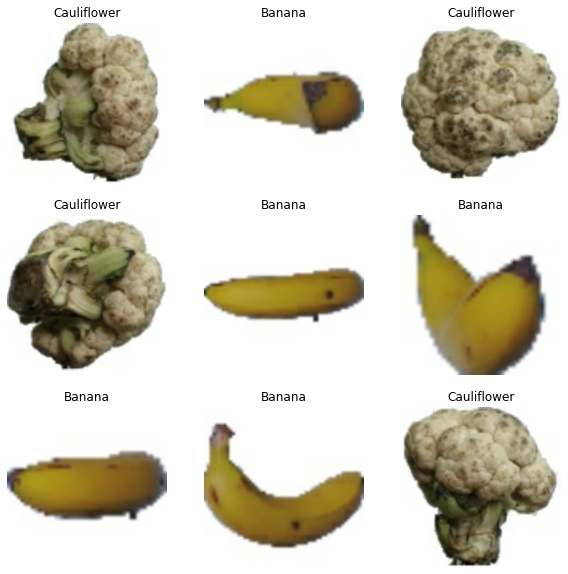

In [19]:
# Dispaly the different fruits/vegetables in the train directory

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [20]:
# Seperating and Storing the train dataset imgaes and labels

train_wholeimage = []
train_wholelabel = []

for images, labels in train_ds.unbatch().take(-1):
    train_wholeimage.append(images)
    train_wholelabel.append(labels)

In [21]:
# Converting the list to array

train_wholeimage = np.asarray(train_wholeimage, dtype=np.float32)
train_wholelabel= np.asarray(train_wholelabel, dtype=np.float32)
print(train_wholeimage.shape)
print(train_wholelabel.shape)

(1314, 256, 256, 3)
(1314,)


In [22]:
# Seperating and Storing the validation dataset imgaes and labels

val_wholeimage = []
val_wholelabel = []

for images, labels in val_ds.unbatch().take(-1):
    val_wholeimage.append(images)
    val_wholelabel.append(labels)

In [23]:
# Converting the list to array

val_wholelabel= np.asarray(val_wholelabel, dtype=np.float32)
val_wholeimage = np.asarray(val_wholeimage, dtype=np.float32)
print(val_wholeimage.shape)
print(val_wholelabel.shape)

(328, 256, 256, 3)
(328,)


In [24]:
# Creating paris for the training images

def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
   

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")

In [25]:
print(train_wholelabel.dtype)
print(val_wholelabel.dtype)

float32
float32


In [26]:
# Converting the data types of the labels to integers

train_wholelabel = train_wholelabel.astype("uint8")
val_wholelabel = val_wholelabel.astype("uint8")

In [27]:
print(train_wholelabel.dtype)
print(val_wholelabel.dtype)

uint8
uint8


In [28]:
# make train pairs
pairs_train, labels_train = make_pairs(train_wholeimage, train_wholelabel)

In [29]:
# make validation pairs
pairs_val, labels_val = make_pairs(val_wholeimage, val_wholelabel)

In [30]:
print(pairs_train.shape)
print(pairs_val.shape)
print(labels_train.shape)

(2628, 2, 256, 256, 3)
(656, 2, 256, 256, 3)
(2628,)


In [31]:
# Splitting the pairs into two variables for training

x_train_1 = pairs_train[:, 0]  
x_train_2 = pairs_train[:, 1]
print(x_train_1.shape)
print(x_train_2.shape)

(2628, 256, 256, 3)
(2628, 256, 256, 3)


In [32]:
# Splitting the pairs into two variables for validation

x_val_1 = pairs_val[:, 0]  
x_val_2 = pairs_val[:, 1]
print(x_val_1.shape)
print(x_val_2.shape)

(656, 256, 256, 3)
(656, 256, 256, 3)


In [33]:
IMG_SHAPE = x_train_1.shape[1:]
IMG_SHAPE

(256, 256, 3)

In [34]:
# Measuring distance between two vectors(images)

def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [35]:
# Defining the Model

inputx = tf.keras.Input(shape=IMG_SHAPE)
x = tf.keras.layers.BatchNormalization()(inputx)
x = tf.keras.layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(output_classes, activation="tanh")(x)
embedding_network = tf.keras.Model(inputx, x)

In [36]:
input_1 = tf.keras.layers.Input(IMG_SHAPE)
input_2 = tf.keras.layers.Input(IMG_SHAPE)

""" As mentioned above, Siamese Network share weights between tower networks (sister networks). 
To allow this, we will use same embedding network for both tower networks. """

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = tf.keras.layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [37]:
# Loss Function

def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

  Arguments:
      margin: Integer, defines the baseline for distance for which pairs
              should be classified as dissimilar. - (default is 1).

  Returns:
      'contrastive_loss' function with data ('margin') attached.
  """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

      Arguments:
          y_true: List of labels, each label is of type float32.
          y_pred: List of predictions of same length as of y_true,
                  each label is of type float32.

      Returns:
          A tensor containing contrastive loss as floating point value.
      """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [38]:
# Model compilation

siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 4)            478224      ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [ ]:
# Fitting the model

history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/10
 46/263 [====>.........................] - ETA: 2:44 - loss: 0.2681 - accuracy: 0.3761

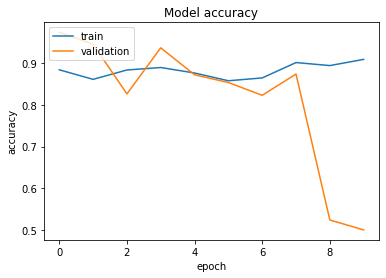

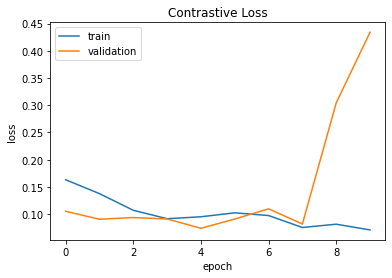

In [ ]:
# Accuracy VS Epoch - Plotting the Metrics

def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")


In [ ]:
# Model Evaluation

results = siamese.evaluate([x_val_1, x_val_2], labels_val) #suppose is x_test_1
print("test loss, test acc:", results)

19/19 [==============================] - 17s 902ms/step - loss: 0.4342 - accuracy: 0.5000
test loss, test acc: [0.4341527223587036, 0.5]


In [ ]:
# Visualize the predicted model

def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1))
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

In [ ]:
# Model Prediction

predictions = siamese.predict([x_val_1, x_val_2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


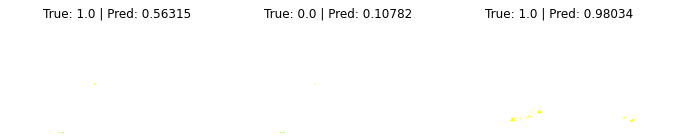

In [ ]:
visualize(pairs_val, labels_val, to_show=3, predictions=predictions, test=True)